In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import warnings

%load_ext autoreload
%autoreload 2

from src.features import *
from src.utils import *
from src.models import *
from src.optimizers import *
from src.loss_functions import *
from src.dataloaders import *
from src.security import NEPTUNE_TOKEN
from src.pipeline_functions import *

plt.style.use("ggplot")
# show all columns
pd.set_option("display.max_columns", None)

warnings.filterwarnings("ignore")

In [3]:
stocks = ["SPY", "VTV", "VUG", "VYM", "QQQ", "VNQ", "GLD", "AGG", "SOXX", "OIH", "IYT", "XLF", "XLV", "VOX", "XLY", "XLP", "BND", "BSV", "IEMG", "VEA", "VWO"]
stocks = sorted(stocks)

stock_classes = {'AGG': 'EQUITY', 'GLD': 'COMMODITY', 'IYT': 'EQUITY', 'OIH': 'EQUITY', 'QQQ': 'EQUITY',
                 'SOXX': 'EQUITY', 'SPY': 'EQUITY', 'VNQ': 'REAL_ESTATE', 'VOX': 'EQUITY', 'VTV': 'EQUITY',
                 'VUG': 'EQUITY', 'VYM': 'EQUITY', 'XLF': 'EQUITY', 'XLP': 'EQUITY', 'XLV': 'EQUITY', 'XLY': 'EQUITY',
                 "BND": "FIXED_INCOME", "BSV": "FIXED_INCOME", "IEMG": "EQUITY", "VEA": "EQUITY", "VWO": "EQUITY"
}

classes_color = {'EQUITY': 'salmon', 'COMMODITY': 'cyan', 'FIXED_INCOME': 'lightgreen', "REAL_ESTATE": "lightblue"}

len(stocks)

21

In [4]:
path = "C:\\Users\\Андрей\\Documents\\diploma_python\\data"

df_adj_close, df_close, df_high, df_low, df_volume = get_data(path, stocks)

AGG Start of history: 2003-09-29
BND Start of history: 2007-04-10
BSV Start of history: 2007-04-10
GLD Start of history: 2004-11-18
IEMG Start of history: 2012-10-24
IYT Start of history: 2004-01-02
OIH Start of history: 2001-02-26
QQQ Start of history: 1999-03-10
SOXX Start of history: 2001-07-13
SPY Start of history: 1993-01-29
VEA Start of history: 2007-07-26
VNQ Start of history: 2004-09-29
VOX Start of history: 2004-09-29
VTV Start of history: 2004-01-30
VUG Start of history: 2004-01-30
VWO Start of history: 2005-03-10
VYM Start of history: 2006-11-16
XLF Start of history: 1998-12-22
XLP Start of history: 1998-12-22
XLV Start of history: 1998-12-22
XLY Start of history: 1998-12-22


In [5]:
nodes_matrix, combined_adj_matrix, cov_adj_matrix, future_return, df_return, df_features = features_pipeline(df_adj_close, df_close, df_high, df_low, df_volume, stocks=stocks)

Features generated and scaled
Return features generated
Correlation and covariance matrices generated
Common index length 2416


100%|██████████| 2416/2416 [05:12<00:00,  7.73it/s]

Adjacency matrices generated
Pipeline finished


In [6]:
TRAIN = 1800
PERIOD = 90 #max window for features' calculation

train_dataset = Dataset(nodes_matrix[:TRAIN], 
                          combined_adj_matrix[:TRAIN], 
                          cov_adj_matrix[:TRAIN], 
                          future_return[:TRAIN])

test_dataset = Dataset(nodes_matrix[TRAIN+PERIOD:],
                            combined_adj_matrix[TRAIN+PERIOD:],
                            cov_adj_matrix[TRAIN+PERIOD:],
                            future_return[TRAIN+PERIOD:])

len(test_dataset)

526

In [7]:
cases = {0: 5, 1: 10, 2: 15, 3: 20}

In [8]:
model_dic = {}
SEED = 45

for i in range(4):
    set_seed(SEED)

    model = GrossModel(num_features=23, num_relations=5, num_assets=21, sample_size=cases[i], pred_window=5, n_heads=1)
    
    optim = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

    _, _ = train(model, optim, train_dataset, epochs=4,
                                eval_func='sharpe_loss', exp_name=f'exp_3105_constraints_v{i}', neptune_token=NEPTUNE_TOKEN,
                                neptune_project="aibabynin/graphs", tags=["samplesize"])
    
    model_dic[i] = {"model": model,
                    "optimizer": optim}

    print(f"{i} is trained")

https://app.neptune.ai/aibabynin/graphs/e/GRAP-53
Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 14 operations to synchronize with Neptune. Do not kill this process.
All 14 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/aibabynin/graphs/e/GRAP-53/metadata
0 is trained
https://app.neptune.ai/aibabynin/graphs/e/GRAP-54
Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 8 operations to synchronize with Neptune. Do not kill this process.
All 8 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/aibabynin/graphs/e/GRAP-54/metadata
1 is trained
https://app.neptune.ai/aibabynin/graphs/e/GRAP-55
Shutting down background jobs, please wait a moment...
Done!
All 0 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/aibabynin/graphs/e/GRAP-55/metadata
2 is trained
htt

In [9]:
for i in range(4):
    torch.save(model_dic[i]['model'].state_dict(), f"model_sample_size_{i}_sr.pt")

In [24]:
for i in range(4):
    model_dic[i]['model'].gamma = torch.nn.Parameter(torch.FloatTensor([0.05]))
    
    test_weights_matrix = evaluate(model_dic[i]['model'], test_dataset)
    model_dic[i]['test_weights_matrix'] = test_weights_matrix
    
    print(f"{i} is evaluated")

100%|██████████| 516/516 [00:09<00:00, 53.30it/s]


0 is evaluated


100%|██████████| 511/511 [00:17<00:00, 28.76it/s]


1 is evaluated


100%|██████████| 506/506 [00:29<00:00, 17.13it/s]


2 is evaluated


100%|██████████| 501/501 [00:37<00:00, 13.45it/s]

3 is evaluated


In [32]:
ret = df_return.iloc[TRAIN + PERIOD + model_dic[3]['model'].sample_size + model.pred_window:].values
index = df_return.iloc[TRAIN + PERIOD + model_dic[3]['model'].sample_size + model.pred_window:].index

returns_matrix = np.zeros((4, len(ret)))

for i in range(4):

    returns_matrix[i] = (ret * model_dic[i]['test_weights_matrix'][-501:, :]).sum(1)

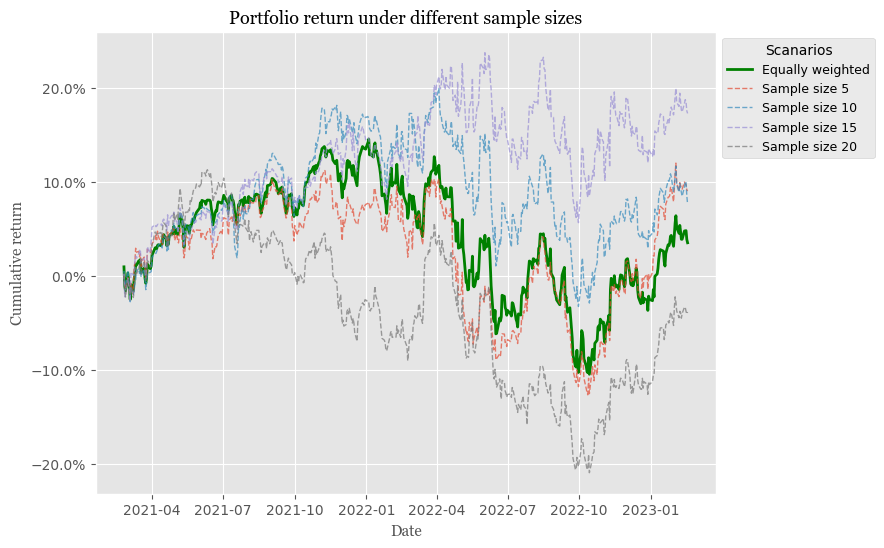

In [33]:
plt.style.use('ggplot')
plt.figure(figsize=(8, 6))
_ = plt.plot(index, (ret.mean(1)+1).cumprod()- 1, color='green', label='Equally weighted', linewidth=2)

for i in range(4):
    _ = plt.plot(index, (returns_matrix[i]+1).cumprod()- 1, alpha=0.7, linestyle='--', label=f'Sample size {cases[i]}', linewidth=1)

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.xlabel('Date', fontsize=11, fontname='Georgia')
plt.ylabel('Cumulative return', fontsize=11, fontname='Georgia')
plt.title('Portfolio return under different sample sizes', fontsize=13, fontname='Georgia')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Scanarios', fontsize=9)
plt.show()

In [28]:
stat_dict = {}

for i in range(4):
    stat_dict[i] = {}
    ret = ((returns_matrix[i]+1).cumprod()- 1)[-1]
    std = returns_matrix[i].std()*np.sqrt(returns_matrix[i].shape[0])
    stat_dict[i]['sr'] = ret/std
    stat_dict[i]['return']  = ret
    stat_dict[i]['std'] = std

In [29]:
stat_dict

{0: {'sr': 0.3838128584136513,
  'return': 0.09026974788229447,
  'std': 0.2351920888096119},
 1: {'sr': 0.3247780681046932,
  'return': 0.07620889838643397,
  'std': 0.23464915236169148},
 2: {'sr': 0.7100573200871028,
  'return': 0.17285501346523335,
  'std': 0.24343811207245808},
 3: {'sr': -0.16199595039278217,
  'return': -0.03851341298129174,
  'std': 0.23774306016854438}}

In [35]:
ret = df_return.iloc[TRAIN + PERIOD + model_dic[3]['model'].sample_size + model.pred_window:].values
index = df_return.iloc[TRAIN + PERIOD + model_dic[3]['model'].sample_size + model.pred_window:].index

print(f'return {((ret.mean(1)+1).cumprod()- 1)[-1]}')
print(f'sharpe {((ret.mean(1)+1).cumprod()- 1)[-1] / (ret.std()*np.sqrt(ret.shape[0]))}')


return 0.03519441893770581
sharpe 0.1119466525853494
